# Collaborative Filtering in Movielens

### Information about the dataset
https://files.grouplens.org/datasets/movielens/ml-25m-README.html <br>

## Content of the files
<b>links.csv</b> > movieId,imdbId,tmdbId > Information on how to link movies to other data sources<br>
<b>movies.csv</b> > movieId,title,genres > Information about the movies based on its Id. Not relevant for the model creation but to map movies if needed<br>
<b>ratings.csv</b> > userId,movieId,rating,timestamp > Rating that each user has provided to the movies. This is the dataset used to build the model<br>
<b>tags.csv</b> > userId,movieId,tag,timestamp > User-added tags to movies. Not relevant for our purpose

## Exploratory Data Analysis

As usual, we will start loading the datasets and required libraries

In [23]:
#Import the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import SVD,Dataset
from scipy.sparse.linalg import svds

In [24]:
#Dataset that will be used to create the model
df_ratings = pd.read_csv('ratings.csv')

#Auxiliary datasets that might be needed later
df_links = pd.read_csv('links.csv')
df_movies = pd.read_csv('movies.csv')
df_tags = pd.read_csv('tags.csv')

First, we will create a pivot table and describing it. Columns are the movies, indexes are the users and the values are the ratings each user has provided for each movie or NaN if there is a movie that hasn't been rated by a user.

In [25]:
original_pivot_df = df_ratings.pivot(index='userId',columns='movieId',values='rating')
missing_values_count = original_pivot_df.isnull().values.sum()
total_values_count = original_pivot_df.size
sparsity = missing_values_count/total_values_count

print('Shape of the pivot table (userId x movieId): {}'.format(original_pivot_df.shape))
print('Number of missing values {}'.format(missing_values_count))
print('Total number of values {}'.format(total_values_count))
print('Sparsity of the matrix {}/{} = {}'.format(missing_values_count,total_values_count,sparsity))

original_pivot_df

Shape of the pivot table (userId x movieId): (610, 9724)
Number of missing values 5830804
Total number of values 5931640
Sparsity of the matrix 5830804/5931640 = 0.9830003169443864


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plots and descriptive statistics
We are plotting the ratings distribution and the count of ratings per user to have a visual aid on the data. From the data in the plots we are also printing its descriptive statistics.

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


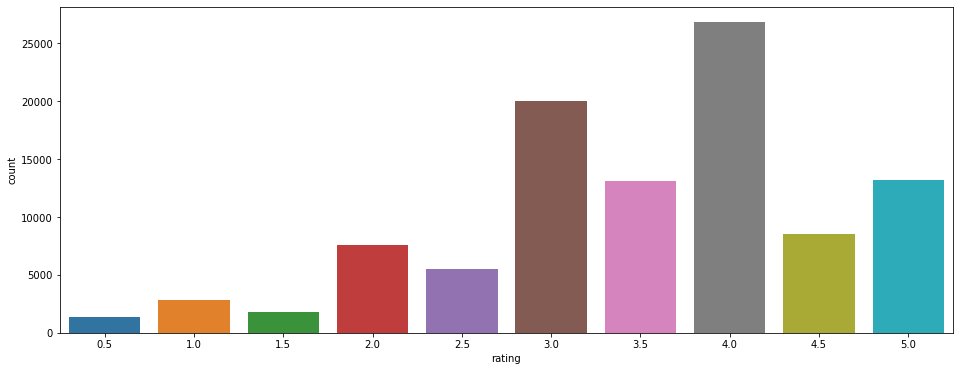

In [26]:
plt.figure(figsize=(16, 6))
print(df_ratings['rating'].describe())
_ = sns.countplot(x='rating',data=df_ratings)

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: userId, dtype: float64


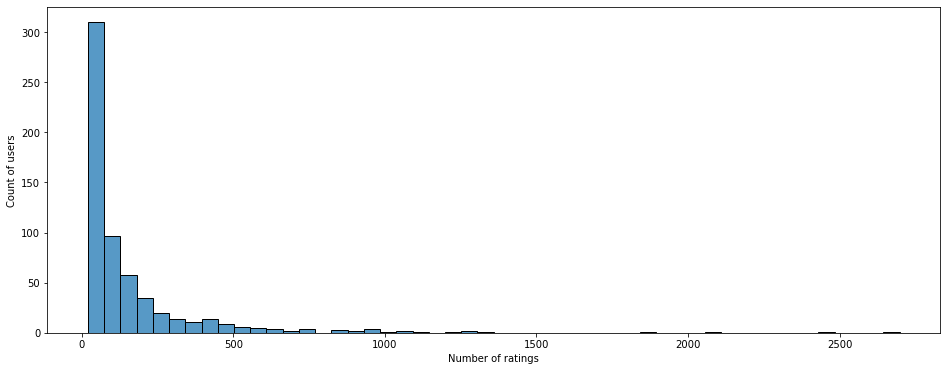

In [27]:
plt.figure(figsize=(16, 6))
print(df_ratings['userId'].value_counts().describe())
_ = sns.histplot(data=df_ratings['userId'].value_counts(),stat='count',bins=50).set(xlabel='Number of ratings',ylabel='Count of users')

### Conclusion from EDA
1. Since the sparsity of the pivot table is more than 98%, traditional ML algorithms like KNN may not work well.
2. More than 75% of the ratings were higher than 3, the most common rating was 4 and ratings have a mean of 3.5
3. Most of the users have provided less than 300 reviews with mean of 165 and value of 70 in the 50th percentile

## Model creation and training

Based on our Exploratory Data Analysis, we will use Singular Value Decomposition algorithm to fill in missing values to be able to predict how every user would rate each movie. We will use surprise library due to its simplicity and reliability but we will also use scipy to compare if the results between the two libraries is consistent

### SVD using scipy library
We will use the scipy library to estimate the missing values in the pivot table. Before applying SVD, we will center all values towards 0 (substracting the mean per user); after applying SVD, we will add the means per user so our ratings are in the same original scale. At the end we will see the pivot with all the missing values filled in. The tradeoff is a small difference in the rating of movies actually rated.

In [28]:
#Getting the mean of the ratings provided by each user
average_rating_per_user = original_pivot_df.mean(axis=1).values

#Substracting the mean from the original pivot table so all values are centered towards 0, so we can fill in the missing
#values with the mean that the user has provided
centered_pivot_df = original_pivot_df.sub(average_rating_per_user,axis=0).fillna(0)

#Getting the value decomposition using SVD
U, sigma, Vt = svds(centered_pivot_df)
sigma = np.diag(sigma)
recalculated_pivot_df = np.dot(np.dot(U,sigma),Vt)

#Adding the average rating per user to the recalculated pivot and adding columns and indexes
recalculated_ratings_svd = pd.DataFrame(
    recalculated_pivot_df + average_rating_per_user.reshape(-1,1),
    index=original_pivot_df.index,
    columns=original_pivot_df.columns)

recalculated_ratings_svd

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.462314,4.349185,4.389132,4.355828,4.304889,4.379954,4.339853,4.353081,4.371022,4.304191,...,4.366366,4.366333,4.366399,4.366399,4.366366,4.366399,4.366366,4.366366,4.366366,4.366969
2,3.947867,3.948730,3.943345,3.948975,3.954781,3.955014,3.950488,3.949590,3.946458,3.960781,...,3.948267,3.948247,3.948288,3.948288,3.948267,3.948288,3.948267,3.948267,3.948267,3.948270
3,2.406305,2.439618,2.420748,2.440964,2.468875,2.461135,2.451152,2.439374,2.424418,2.481790,...,2.435862,2.435774,2.435949,2.435949,2.435862,2.435949,2.435862,2.435862,2.435862,2.435745
4,3.616146,3.556886,3.576326,3.551370,3.500886,3.497739,3.521390,3.555289,3.562753,3.490580,...,3.555621,3.555780,3.555462,3.555462,3.555621,3.555462,3.555621,3.555621,3.555621,3.555394
5,3.653970,3.633074,3.646911,3.631662,3.620151,3.628583,3.628683,3.635113,3.640487,3.596743,...,3.636387,3.636443,3.636330,3.636330,3.636387,3.636330,3.636387,3.636387,3.636387,3.636556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.897556,3.566707,3.688992,3.599346,3.434501,3.736443,3.544275,3.646346,3.650694,3.282278,...,3.657630,3.658191,3.657068,3.657068,3.657630,3.657068,3.657630,3.657630,3.657630,3.659773
607,3.818336,3.773703,3.799590,3.778775,3.742178,3.779247,3.769289,3.778643,3.796693,3.733471,...,3.786128,3.786204,3.786051,3.786051,3.786128,3.786051,3.786128,3.786128,3.786128,3.786412
608,3.446540,2.838885,2.682081,3.117258,2.706645,3.795240,2.909024,3.114491,2.974129,3.601215,...,3.134140,3.134052,3.134227,3.134227,3.134140,3.134227,3.134140,3.134140,3.134140,3.134150


#### Predictions using scipy library

In [29]:
#Retrieving the rating for one of the users by its Id(1-610)
userId = 100
user_rating = pd.DataFrame(recalculated_ratings_svd.loc[userId,:].values.reshape(-1,1),index=original_pivot_df.columns)
user_rating = user_rating.reset_index()
user_rating = user_rating.merge(df_movies,on='movieId')
user_rating.columns = ['movieId','predicted_rating','title','genres']
user_rating = user_rating.set_index('movieId')

top_movies = user_rating.sort_values(by='predicted_rating',ascending=False)[:10]
bottom_movies = user_rating.sort_values(by='predicted_rating')[:10]

In [30]:
#Showing top movies for the provided userId
top_movies

,predicted_rating,title,genres
movieId,,,
356,4.016539,Forrest Gump (1994),Comedy|Drama|Romance|War
318,4.008770,"Shawshank Redemption, The (1994)",Crime|Drama
364,4.006878,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
4306,4.006468,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...
527,4.001358,Schindler's List (1993),Drama|War
8368,4.001226,Harry Potter and the Prisoner of Azkaban (2004),Adventure|Fantasy|IMAX
3994,3.996407,Unbreakable (2000),Drama|Sci-Fi
2628,3.996149,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi
5816,3.992182,Harry Potter and the Chamber of Secrets (2002),Adventure|Fantasy


In [31]:
#Showing bottom movies for the provided userId
bottom_movies

,predicted_rating,title,genres
movieId,,,
924,3.864166,2001: A Space Odyssey (1968),Adventure|Drama|Sci-Fi
1208,3.866635,Apocalypse Now (1979),Action|Drama|War
1206,3.867773,"Clockwork Orange, A (1971)",Crime|Drama|Sci-Fi|Thriller
1732,3.877645,"Big Lebowski, The (1998)",Comedy|Crime
1228,3.878551,Raging Bull (1980),Drama
541,3.885424,Blade Runner (1982),Action|Sci-Fi|Thriller
608,3.889795,Fargo (1996),Comedy|Crime|Drama|Thriller
1089,3.891100,Reservoir Dogs (1992),Crime|Mystery|Thriller
2710,3.893911,"Blair Witch Project, The (1999)",Drama|Horror|Thriller


### SVD using SVD library
Now we will try to replicate the same results as before, this time using SVD from surprise library. This library handles all the complexity for us so we only need to make sure we are providing the same dataset to the SVD. Since the results are not provided in a DataFrame, we will use some methods to retrieve the top and bottom predictions

In [32]:
from collections import defaultdict
from surprise import SVD
from surprise import Dataset
from surprise import Reader

def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

def get_bottom_n(predictions, n=10):
    # First map the predictions to each user.
    bottom_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        bottom_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in bottom_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=False)
        bottom_n[uid] = user_ratings[:n]

    return bottom_n


# First train an SVD algorithm on the movielens dataset.
data = Dataset.load_from_df(df_ratings.iloc[:,:3],Reader(rating_scale=(.5, 5)))
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

#### Predictions using suprise library

In [33]:
#Generating top movies for the provided userId
top_n = get_top_n(predictions, n=10)
top_n_ids = [movie[0] for movie in top_n[userId]]
top_n_rating = [movie[1] for movie in top_n[userId]]
user_top_ratings_surprise = pd.DataFrame()
user_top_ratings_surprise['movieId'] = top_n_ids
user_top_ratings_surprise['predicted_rating'] = top_n_rating
user_top_ratings_surprise = user_top_ratings_surprise.merge(df_movies,on='movieId')
user_top_ratings_surprise.columns = ['movieId','predicted_rating','title','genres']
user_top_ratings_surprise = user_top_ratings_surprise.set_index('movieId')

top_movies = user_top_ratings_surprise.sort_values(by='predicted_rating',ascending=False)[:10]

In [34]:
bottom_n = get_bottom_n(predictions, n=10)
bottom_n_ids = [movie[0] for movie in bottom_n[userId]]
bottom_n_rating = [movie[1] for movie in bottom_n[userId]]
user_bottom_ratings_surprise = pd.DataFrame()
user_bottom_ratings_surprise['movieId'] = bottom_n_ids
user_bottom_ratings_surprise['predicted_rating'] = bottom_n_rating
user_bottom_ratings_surprise = user_bottom_ratings_surprise.merge(df_movies,on='movieId')
user_bottom_ratings_surprise.columns = ['movieId','predicted_rating','title','genres']
user_bottom_ratings_surprise = user_bottom_ratings_surprise.set_index('movieId')

bottom_movies = user_bottom_ratings_surprise.sort_values(by='predicted_rating')[:10]

In [35]:
#Showing top movies for the provided userId
top_movies

,predicted_rating,title,genres
movieId,,,
1204,4.815901,Lawrence of Arabia (1962),Adventure|Drama|War
1104,4.753191,"Streetcar Named Desire, A (1951)",Drama
246,4.739186,Hoop Dreams (1994),Documentary
750,4.711592,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
912,4.688222,Casablanca (1942),Drama|Romance
1704,4.678849,Good Will Hunting (1997),Drama|Romance
1178,4.671031,Paths of Glory (1957),Drama|War
1248,4.663241,Touch of Evil (1958),Crime|Film-Noir|Thriller
3451,4.660171,Guess Who's Coming to Dinner (1967),Drama


In [36]:
#Showing bottom movies for the provided userId
bottom_movies

,predicted_rating,title,genres
movieId,,,
1562,2.638913,Batman & Robin (1997),Action|Adventure|Fantasy|Thriller
1760,2.647268,Spice World (1997),Comedy
1499,2.654481,Anaconda (1997),Action|Adventure|Thriller
1882,2.654699,Godzilla (1998),Action|Sci-Fi|Thriller
1556,2.654981,Speed 2: Cruise Control (1997),Action|Romance|Thriller
2338,2.655565,I Still Know What You Did Last Summer (1998),Horror|Mystery|Thriller
1644,2.722780,I Know What You Did Last Summer (1997),Horror|Mystery|Thriller
1381,2.736647,Grease 2 (1982),Comedy|Musical|Romance
5323,2.747577,Jason X (2002),Horror|Sci-Fi|Thriller


### SVD scipy vs SVD suprise
After comparing the results between the two libraries using the same algorithm, I noticed the results are different. Is important to notice that although the results are different between the algorithms, the top and bottom movies are consisent (i.e. the genres or movie titles are pretty similar in each of the 4 tables shown above).<br>
After some investigation, it looks like the difference is in the step that has to be done in scipy library to center the values towards 0 and then adding the average. So in contrast:
#### Surprise 
To estimate all the unknown, it minimizes the a regularized squared error function. The minimization is performed by a very straightforward stochastic gradient descent (source: https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)
#### Scipy
To estimate all the unknown, we have to center all values towards 0 (substracting the mean per user), then apply SVD, and finally we will add the means per user so our ratings are in the same original scale

## Conclusion
After analizing the SVD algorithm in both libraries, the results in suprise are much simpler and make a bit more sense than those of scipy. Taking as example userId = 100 in suprise library, we can see that this user likes Drama and War movies but doesn't like Horror and Thriller movies. These predictions make a lot of sense since both top and bottom movies are pretty similar each other.